# **Projeto Volvo**

##Estimativa de valores de horímetro das máquinas da frota circulante

[Drive Volvo](https://drive.google.com/drive/folders/1HS80lS_XzGH7Tz9juk08d2IR65zZ4Cyv)

[Nosso Drive](https://drive.google.com/drive/folders/1QSw-csAJ1tW1FgAQQOY3tkXMBFcb2hmR?usp=sharing)


#0 - Informações sobre o projeto

###Projeto Volvo Construction Equipments na América Latina

####**Problema**
Dificuldade de obter dados da frota circulante, o que atrapalha a gestão e impacta o cliente

####**Perguntas**

1.   Como poderíamos inferir a partir de uma amostra da população de máquinas o valor de horímetro de um equipamento que não está comunicando através do dispositivo de telemetria?
2.   Seria possível estimar padrões de operação diária de um equipamento que não nos envia dados?


####**Solução**

Com base no histórico de dados, verificar se é possível prever padrões de operação diária de um equipamento (horímetro) que envia/não envia dados.


####**Objetivo**

Melhorar a gestão da frota circulante para que se alcance:

* o aumento da eficiência operacional da rede de distribuição
* a antecipação de necessidades dos clientes
* o aumento da produtividade das máquinas (uptime)
* a identificação de novas oportunidades em vendas de peças e serviços que não são exploradas
* o aumento de satisfação dos clientes Volvo CE

#1 - Hipóteses
*a serem testadas após o desenvolvimento do modelo preditivo*

* H0: É possível prever o horímetro da máquina com base no histórico de registros com precisão significativamente maior que a fornecida pelo cálculo atual (baseado em médias)
* H1: É possivel utilizar a mesma técnica para os 3 cenários de medição do problema?
1.   máquinas que enviaram dados nos últimos 4 dias
2.   máquinas que enviaram dados mas não recententemente
3.   máquinas que nunca enviaram dados
* H2: A técnica proposta garante resultados independentemente da classe da máquina: AHL; WL; EXC?
* H3: A técnica proposta garante resultados independentemente do segmento de aplicação da máquina?
* H4: A técnica proposta garante resultados independentemente do país onde a máquina está localizada?
* H5: A técnica proposta garante resultados independentemente do Dealer que realizou a venda?
* H6: A técnica proposta garante resultados independentemente da idade da máquina?

#2 - Dicionário

###**Variáveis**

**Dataset de equipamentos**

* Região: regiões de vendas. São 3 ('Hispânico Sul', 'Brasil', 'Hispânico Norte')

* País: onde a máquina foi comprada. São 3 ('Argentina', 'Brasil', 'México')

* Dealer: revendedor de peças. São 7 ('EPSA', 'Dinâmica', 'Gotemburgo', 'Linck', 'Tecnoeste', 'Tracbel', 'Ascendum')

* Segmento: atuação da máquina. São 5 ('Mining', 'Construction', 'Forestry', 'Agriculture', 'Industry')

* Modelo: linha da máquina WLO (Wheel Loader ou máquinas com pás articuladas), EXC (escavadeiras) e ART (caminhões articulados) ('ART', 'EXC', 'WLO')

* Chassis ID

* PIN17: identificação mais detalhada da máquina (não relevante para a análise)

* Delivery Date: data em que a máquina começou a trabalhar

* Obs.: observações internas da Volvo sobre a coleta de dados (não relevante para a análise)

* Estado: estado onde a máquina está operando atualmente ('San Luis', 'San Juan', 'Entre Ríos', 0, 'Jujuy','Provincia de Buenos Aires', 'Misiónes', 'Catamarca Province','Minas Gerais', 'Pará', 'Mato Grosso', 'Rondônia', 'Pernambuco','Bahia', 'Sergipe', 'Rio Grande do Norte', 'Paraná','Rio Grande do Sul', 'Santa Catarina', 'São Paulo','Mato Grosso do Sul', 'Rio de Janeiro', 'Veracruz','Estado de México', 'Nuevo León', 'Querétaro', 'Hidalgo','Coahuila de Zaragoza', 'Tabasco')

* Região: país onde a máquina está operando atualmente (pode diferir da de venda)

**Dataset de séries temporais**

* Chassis ID

* Machine History Date Day: dia no histórico de datas da máquina (dia de registro das horas)

* Compensated Working Hours By Day: quantidade de horas trabalhadas no dia

###**Outros**

Volvo CE: Volvo Construction Equipment

Horímetro: Quantidade de horas de operação que um equipamento tem

POC: proof of concept, a demonstration of a product in which work is focused on determining whether an idea can be turned into a reality

#3 - Importando bibliotecas

In [1]:
import pandas_flavor as pf
import janitor

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
#from google.colab import drive
import matplotlib.pyplot as plt
from ipywidgets import interact
import statsmodels.api as sm

# bibliotecas para os modelos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# bibliotecas de métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#4 - Importando Dados

In [4]:
# importando o conjunto de dados
pd.set_option('display.max_columns', None)
#drive.mount('/content/drive')

equip = pd.read_excel('Dados/23w06_Equipamentos.xlsx')
temporal = pd.read_excel('Dados/23w06_SeriesTemporais_Horimetros.xlsx')

#5 - Analisando dados

In [5]:
# observando dataset equip
equip.head(2)

,Região,País,Dealer,Segmento,Modelo,Chassis ID,PIN17,Delivery Date,Obs.:,Estado,Região.1
0,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,VCEA040FCG0320538,2020-11-26,NaN,San Luis,Argentina
1,Hispânico Sul,Argentina,EPSA,Construction,ART,A30G732052,VCE0A30GCL0732052,2020-06-22,NaN,San Juan,Argentina


In [6]:
# observando informações básicas de equip
equip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Região         63 non-null     object        
 1   País           63 non-null     object        
 2   Dealer         63 non-null     object        
 3   Segmento       63 non-null     object        
 4   Modelo         63 non-null     object        
 5   Chassis ID     63 non-null     object        
 6   PIN17          57 non-null     object        
 7   Delivery Date  62 non-null     datetime64[ns]
 8   Obs.:          15 non-null     object        
 9   Estado         63 non-null     object        
 10  Região.1       63 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 5.5+ KB


In [7]:
# verificando quantos valores nulos equip tem
equip.isna().sum()

Região            0
País              0
Dealer            0
Segmento          0
Modelo            0
Chassis ID        0
PIN17             6
Delivery Date     1
Obs.:            48
Estado            0
Região.1          0
dtype: int64

In [8]:
# identificando o índice do valor nulo de `Delivery Date`
indices_nulos = equip[equip['Delivery Date'].isnull()].index
print(indices_nulos)

Index([22], dtype='int64')


In [9]:
# verificando qual ID está sem delivery date
print(equip.loc[22, 'Chassis ID'])

EC220240109


In [10]:
# removendo variáveis não relevantes e renomeando variáveis
equip = equip.drop(columns = ['Obs.:', 'PIN17'])
equip = equip.rename(columns={'Região.1': 'pais_operacao', 'País': 'pais_compra', 'Chassis ID': 'ID'})

In [11]:
# observando dataset temporal
temporal.head(2)

,Chassis Id*,Machine History Date Day,Compensated Working Hours By Day
0,A030F720057,2016-12-09,0.00
1,A030F720057,2016-12-10,5.75


In [12]:
# observando informações básicas de temporal
temporal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118161 entries, 0 to 118160
Data columns (total 3 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Chassis Id*                       118161 non-null  object        
 1   Machine History Date Day          118161 non-null  datetime64[ns]
 2   Compensated Working Hours By Day  118161 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.7+ MB


In [13]:
# verificando quantos valores nulos temporal tem
temporal.isna().sum()

Chassis Id*                         0
Machine History Date Day            0
Compensated Working Hours By Day    0
dtype: int64

In [14]:
# verificando quantos IDs temporal tem
len(temporal['Chassis Id*'].unique())

62

In [15]:
# verificando se o ID EC220240109 consta no dataset temporal
busca = temporal.loc[temporal['Chassis Id*'] == 'EC220240109'].index[0]
busca

38422

In [16]:
# verificando qual ID o equip tem a mais que temporal
chassis_temp = temporal['Chassis Id*'].unique()
chassis_equip = equip['ID'].unique()
valor_adicional = set(chassis_equip) - set(chassis_temp)

print(valor_adicional)

{'A30F720054'}


In [17]:
# renomeando variável
temporal = temporal.rename(columns={'Compensated Working Hours By Day': 'Horas', 'Machine History Date Day': 'Dia', 'Chassis Id*': 'ID'})

In [18]:
# removendo ID A30F720054
equip = equip.drop(equip[equip['ID'] == 'A30F720054'].index)

In [19]:
# observando os valores dos IDs no temporal
chassis_valores = temporal.groupby('ID').describe()
chassis_valores

Dia                                                      \
            count                           mean                  min   
ID                                                                      
A030F720057  1805  2020-06-01 19:47:06.149584384  2016-12-09 00:00:00   
A040F320538  2241  2020-01-10 12:20:53.012048128  2016-12-14 00:00:00   
A040F320657  2121            2020-03-15 00:00:00  2017-04-20 00:00:00   
A040F320672  2121            2020-03-15 00:00:00  2017-04-20 00:00:00   
A30F072791   3041            2018-12-11 00:00:00  2014-10-13 00:00:00   
...           ...                            ...                  ...   
L60F073972    921            2021-11-05 00:00:00  2020-08-02 00:00:00   
L60F074089    916  2021-11-07 12:00:00.000000256  2020-08-07 00:00:00   
L60F074104    897            2021-11-17 00:00:00  2020-08-26 00:00:00   
L60F074121    891            2021-11-20 00:00:00  2020-09-01 00:00:00   
L60F074213    808            2021-12-31 12:00:00  2020-11-23 00:00:00   

                                                                            \
                             25%                  50%                  75%   
ID                                                                           
A030F720057  2019-05-27 00:00:00  2020-08-20 00:00:00  2021-11-14 00:00:00   
A040F320538  2018-06-27 00:00:00  2020-01-08 00:00:00  2021-07-28 00:00:00   
A040F320657  2018-10-02 00:00:00  2020-03-15 00:00:00  2021-08-27 00:00:00   
A040F320672  2018-10-02 00:00:00  2020-03-15 00:00:00  2021-08-27 00:00:00   
A30F072791   2016-11-11 00:00:00  2018-12-11 00:00:00  2021-01-09 00:00:00   
...                          ...                  ...                  ...   
L60F073972   2021-03-20 00:00:00  2021-11-05 00:00:00  2022-06-23 00:00:00   
L60F074089   2021-03-23 18:00:00  2021-11-07 12:00:00  2022-06-24 06:00:00   
L60F074104   2021-04-07 00:00:00  2021-11-17 00:00:00  2022-06-29 00:00:00   
L60F074121   2021-04-11 12:00:00  2021-11-20 00:00:00  2022-06-30 12:00:00   
L60F074213   2021-06-12 18:00:00  2021-12-31 12:00:00  2022-07-21 06:00:00   

                                        Horas                             \
                             max  std   count       mean  min        25%   
ID                                                                         
A030F720057  2023-02-08 00:00:00  NaN  1805.0   6.851108  0.0   0.000446   
A040F320538  2023-02-08 00:00:00  NaN  2241.0   2.885249  0.0   0.001818   
A040F320657  2023-02-08 00:00:00  NaN  2121.0  14.792456  0.0  10.700000   
A040F320672  2023-02-08 00:00:00  NaN  2121.0   4.596603  0.0   0.025926   
A30F072791   2023-02-08 00:00:00  NaN  3041.0  11.465549  0.0   8.950000   
...                          ...  ...     ...        ...  ...        ...   
L60F073972   2023-02-08 00:00:00  NaN   921.0  14.318868  0.0  11.550000   
L60F074089   2023-02-08 00:00:00  NaN   916.0   4.702040  0.0   0.091071   
L60F074104   2023-02-08 00:00:00  NaN   897.0   4.625585  0.0   0.000000   
L60F074121   2023-02-08 00:00:00  NaN   891.0   3.062028  0.0   1.400000   
L60F074213   2023-02-08 00:00:00  NaN   808.0   6.495359  0.0   1.187500   

                                                  
                   50%      75%    max       std  
ID                                                
A030F720057   5.600000  12.4000  57.20  7.257318  
A040F320538   0.004074   4.3000  22.10  5.186442  
A040F320657  18.000000  20.4000  29.40  7.534622  
A040F320672   3.750000   7.2500  23.85  5.129515  
A30F072791   12.500000  16.4000  35.35  5.937882  
...                ...      ...    ...       ...  
L60F073972   15.450000  18.5500  32.50  6.292234  
L60F074089    3.000000   8.7000  28.55  4.962446  
L60F074104    4.900000   7.4500  21.35  3.941112  
L60F074121    2.700000   4.2500  56.35  2.995701  
L60F074213    6.325000   9.5625  26.50  5.074819  

[62 rows x 16 columns]

In [20]:
# juntando os dois datasets para visualizar
df_original = equip.merge(temporal, how = 'left', left_on = 'ID', right_on = 'ID')

In [21]:
df = df_original.copy()

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118161 entries, 0 to 118160
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Região         118161 non-null  object        
 1   pais_compra    118161 non-null  object        
 2   Dealer         118161 non-null  object        
 3   Segmento       118161 non-null  object        
 4   Modelo         118161 non-null  object        
 5   ID             118161 non-null  object        
 6   Delivery Date  115120 non-null  datetime64[ns]
 7   Estado         118161 non-null  object        
 8   pais_operacao  118161 non-null  object        
 9   Dia            118161 non-null  datetime64[ns]
 10  Horas          118161 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(8)
memory usage: 9.9+ MB


In [23]:
# criando gráficos
@interact(id = temporal.ID.unique().tolist())
def graficos(id):
    plt.figure(figsize= (16,3))
    ax = sns.lineplot(data = temporal[temporal.ID == id],
                      x = 'Dia',
                      y = 'Horas')
    plt.show()

interactive(children=(Dropdown(description='id', options=('A030F720057', 'A040F320538', 'A040F320657', 'A040F3…

In [24]:
# criando variável para armazenar as variáveis que vão ser apresentadas na tabela geral
cols = ['Região', 'País Compra','Dealer','Segmento','Modelo','Estado','País Operação', 'ID']

In [25]:
# criando tabela geral para visualizar os principais dados das principais variáveis
@interact(agg_fun = ['sum', 'mean','max'], col_groupby = cols)


def tabela_geral(agg_fun,col_groupby):
    df2 = df.groupby([col_groupby], sort = 'Horas')[['Horas']].agg(agg_fun)\
              .sort_values('Horas', ascending = False)

    return df2.style.highlight_min(color = 'black')\
                    .highlight_max(color = 'lightcoral')

interactive(children=(Dropdown(description='agg_fun', options=('sum', 'mean', 'max'), value='sum'), Dropdown(d…

#6 - Criando novas variáveis


### 6.1 - Método 1: Aplicando One Hot Encoding nas variáveis categóricas

In [26]:
#criando df2 para o Método 2
df2 = df

In [27]:
# aplicando One Hot Encoding às variáveis
df_aux = pd.get_dummies(df['Segmento'], prefix='Segmento')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Modelo'], prefix='Modelo')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Dealer'], prefix='Dealer')
df = pd.concat([df, df_aux], axis=1)
df_aux = pd.get_dummies(df['Região'], prefix='Região')
df = pd.concat([df, df_aux], axis=1)

In [28]:
# deletando variáveis originais
df.drop(['Segmento', 'Modelo', 'Dealer', 'Região'], axis=1, inplace=True)

In [29]:
# apagando os dados vazios
df = df.dropna()

In [30]:
df.head(2)

,pais_compra,ID,Delivery Date,Estado,pais_operacao,Dia,Horas,Segmento_Agriculture,Segmento_Construction,Segmento_Forestry,Segmento_Industry,Segmento_Mining,Modelo_ART,Modelo_EXC,Modelo_WLO,Dealer_Ascendum,Dealer_Dinâmica,Dealer_EPSA,Dealer_Gotemburgo,Dealer_Linck,Dealer_Tecnoeste,Dealer_Tracbel,Região_Brasil,Região_Hispânico Norte,Região_Hispânico Sul
0,Argentina,A040F320538,2020-11-26,San Luis,Argentina,2016-12-14,0.0,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True
1,Argentina,A040F320538,2020-11-26,San Luis,Argentina,2016-12-15,0.0,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,False,False,True


### 6.2 - Método 2: Adicionando médias dos horimetros

In [31]:
dayOfWeek={0:'Seg', 1:'Ter', 2:'Qua', 3:'Qui', 4:'Sex', 5:'Sab', 6:'Dom'}
df2['dia_da_semana'] = df2.Dia.dt.dayofweek.map(dayOfWeek)
df2["mes"] = df2.Dia.dt.month

In [32]:
df2.groupby(['Modelo',"pais_operacao","dia_da_semana"])[["Horas"]].mean().reset_index()

,Modelo,pais_operacao,dia_da_semana,Horas
0,ART,Argentina,Dom,2.076216
1,ART,Argentina,Qua,7.280186
2,ART,Argentina,Qui,6.990743
3,ART,Argentina,Sab,4.979574
4,ART,Argentina,Seg,4.885679
...,...,...,...,...
135,WLO,Sul,Qui,7.747734
136,WLO,Sul,Sab,3.954848
137,WLO,Sul,Seg,7.424557
138,WLO,Sul,Sex,7.789480


In [33]:
df2.groupby(['ID',"dia_da_semana"])[["Horas"]].mean().reset_index()

,ID,dia_da_semana,Horas
0,A030F720057,Dom,1.400040
1,A030F720057,Qua,9.219244
2,A030F720057,Qui,9.591219
3,A030F720057,Sab,4.725538
4,A030F720057,Seg,6.170583
...,...,...,...
429,L60F074213,Qui,8.481739
430,L60F074213,Sab,5.934783
431,L60F074213,Seg,5.556897
432,L60F074213,Sex,8.137391


In [34]:
# Seleciona as colunas para o loop for
cols = ["Região","Dealer","Segmento","Modelo"]

# Coluna que será feito o calculo
agg = ["Horas"]

# Métricas
func = ['mean',"min","max",'median']

In [35]:
for col in cols:
  for fun in func:
    df2 = df2.groupby_agg(by = [col,"dia_da_semana","ID",],
                        agg = fun,
                        agg_column_name = ["Horas"],
                        new_column_name = f'{col}_{fun}_Horas')

In [36]:
for col in cols:
  for fun in func:
    df2 = df2.groupby_agg(by = ["ID", col, "dia_da_semana"],
                        agg = fun,
                        agg_column_name = ["Horas"],
                        new_column_name = f'{col}_{fun}_Horas')

In [41]:
# verificando as correções, porém com o gráfica fica pouca visualização
#sns.heatmap(df2.corr(), annot=True);

In [37]:
# apagando os dados vazios
df2 = df2.dropna()

In [38]:
df2.head(2)

,Região,pais_compra,Dealer,Segmento,Modelo,ID,Delivery Date,Estado,pais_operacao,Dia,Horas,dia_da_semana,mes,Região_mean_Horas,Região_min_Horas,Região_max_Horas,Região_median_Horas,Dealer_mean_Horas,Dealer_min_Horas,Dealer_max_Horas,Dealer_median_Horas,Segmento_mean_Horas,Segmento_min_Horas,Segmento_max_Horas,Segmento_median_Horas,Modelo_mean_Horas,Modelo_min_Horas,Modelo_max_Horas,Modelo_median_Horas
0,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,2020-11-26,San Luis,Argentina,2016-12-14,0.0,Qua,12,3.689488,0.0,21.65,0.004167,3.689488,0.0,21.65,0.004167,3.689488,0.0,21.65,0.004167,3.689488,0.0,21.65,0.004167
1,Hispânico Sul,Argentina,EPSA,Mining,ART,A040F320538,2020-11-26,San Luis,Argentina,2016-12-15,0.0,Qui,12,3.390931,0.0,21.65,0.004545,3.390931,0.0,21.65,0.004545,3.390931,0.0,21.65,0.004545,3.390931,0.0,21.65,0.004545


# **7 - Ajustando e Separando Dados (Treino e Teste)**

### 7.1 - Método 1

In [39]:
# apagando as variaveis categoricas e ficando apenas as numericas PARA O MODELO 1
df.drop(['pais_compra','ID','Delivery Date','Estado','pais_operacao','Dia'], axis=1, inplace=True)

In [40]:
# criando X e y
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115120 entries, 0 to 118160
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   Segmento_Agriculture    115120 non-null  bool 
 1   Segmento_Construction   115120 non-null  bool 
 2   Segmento_Forestry       115120 non-null  bool 
 3   Segmento_Industry       115120 non-null  bool 
 4   Segmento_Mining         115120 non-null  bool 
 5   Modelo_ART              115120 non-null  bool 
 6   Modelo_EXC              115120 non-null  bool 
 7   Modelo_WLO              115120 non-null  bool 
 8   Dealer_Ascendum         115120 non-null  bool 
 9   Dealer_Dinâmica         115120 non-null  bool 
 10  Dealer_EPSA             115120 non-null  bool 
 11  Dealer_Gotemburgo       115120 non-null  bool 
 12  Dealer_Linck            115120 non-null  bool 
 13  Dealer_Tecnoeste        115120 non-null  bool 
 14  Dealer_Tracbel          115120 non-null  bool 
 15  Regiã

### 7.2 - Método 2

In [42]:
# apagando as variaveis categoricas e ficando apenas as numericas
df2.drop(['Região','Dealer','Segmento','Modelo','pais_compra','ID','Delivery Date','Estado','pais_operacao','Dia',"dia_da_semana","mes"], axis=1, inplace=True)

In [69]:
# criando X e y
X = df2.iloc[:, 1:]
y = df2.iloc[:, 0]

### 7.3 Treinando os modelos

In [70]:
# separando dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# **8 - Aplicando Modelos**


### 8.1 - Regressão Linear

In [71]:
# criando modelo de Regressão Linear
modeloLR = LinearRegression()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloLR.fit(X_train, y_train)

LinearRegression()

### 8.2 - Random Forest

In [72]:
# criando modelo Random Forest
modeloRF = RandomForestRegressor(n_estimators=100, min_samples_leaf=2)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRF.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2)

### 8.3 - Random Forest (alterando parâmetros)

In [73]:
# tunando modelo Random Forest
modeloRF2 = RandomForestRegressor(n_estimators=200, min_samples_leaf=2)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRF2.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=2, n_estimators=200)

### 8.4 - Regressão Lasso

In [74]:
# criando modelo de Lasso
modeloRL = Lasso()

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRL.fit(X_train, y_train)

Lasso()

### 8.5 - Regressão de cume (Ridge)

In [75]:
# criando modelo de Cume
modeloRC = Ridge()

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRC.fit(X_train, y_train)

Ridge()

### 8.6 - Regressão de cume (Ridge)2

In [76]:
# criando modelo de Cume
modeloRC2 = Ridge(alpha=0)

# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloRC2.fit(X_train, y_train)

Ridge(alpha=0)

### 8.6 - Regressão XGBoost

In [77]:
# criando modelo de Regressão XGBoost
modeloXGB = XGBRegressor()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloXGB.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 8.7 - Regressão XGBoost2 (alterando parâmetros)

In [78]:
# tunando modelo de Regressão XGBoost
modeloXGB2 = XGBRegressor(n_estimators=2000, max_depth=8)
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloXGB2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 8.8 - Decision Tree Regressor

In [79]:
# criando modelo
modeloDT = DecisionTreeRegressor()
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloDT.fit(X_train, y_train)

DecisionTreeRegressor()

### 8.9 - KNN Regressor

In [80]:
# criando modelo KNN Regressor
modeloKNN = KNeighborsRegressor(n_neighbors=5) # considerando 5 neighbors
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloKNN.fit(X_train, y_train)

KNeighborsRegressor()

### 8.10 - KNN Regressor (alterando parâmetros)

In [81]:
# criando modelo KNN Regressor
modeloKNN2 = KNeighborsRegressor(n_neighbors=6) # considerando 6 neighbors
# fazendo o fit/ajustando o modelo com os dados de treinamento
modeloKNN2.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=6)

### 8.11 - LSTM (Long Short-Term Memory) 

In [82]:
from keras.callbacks import EarlyStopping

# Define o Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [83]:
# 1. Importando bibliotecas necessárias
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 2. Preparando dados 
# Normalizar os dados pode ser uma boa prática ao trabalhar com redes neurais
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Construir o modelo
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model_LSTM.add(LSTM(units=50))
model_LSTM.add(Dense(units=1))

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

# 4. Treinar o modelo
model_LSTM.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.10, callbacks=[early_stopping])


Epoch 1/20
2267/2267 [==============================] - 40s 15ms/step - loss: 26.5814 - val_loss: 24.2032
Epoch 2/20
2267/2267 [==============================] - 34s 15ms/step - loss: 25.8992 - val_loss: 23.9686
Epoch 3/20
2267/2267 [==============================] - 46s 20ms/step - loss: 25.7933 - val_loss: 23.8248
Epoch 4/20
2267/2267 [==============================] - 52s 23ms/step - loss: 25.7561 - val_loss: 23.6962
Epoch 5/20
2267/2267 [==============================] - 40s 18ms/step - loss: 25.4888 - val_loss: 23.2250
Epoch 6/20
2267/2267 [==============================] - 37s 16ms/step - loss: 25.1821 - val_loss: 23.1273
Epoch 7/20
2267/2267 [==============================] - 53s 23ms/step - loss: 25.1674 - val_loss: 23.3533
Epoch 8/20
2267/2267 [==============================] - 70s 31ms/step - loss: 25.1167 - val_loss: 23.3871
Epoch 9/20
2267/2267 [==============================] - 55s 24ms/step - loss: 25.0703 - val_loss: 23.1045
Epoch 10/20
2267/2267 [=======================

In [84]:
# 5. Fazer previsões
predicted_values = model_LSTM.predict(X_test_scaled)

1080/1080 [==============================] - 12s 9ms/step


### 8.12 - BDLSTM (Bidirecional Long Short-Term Memory) 

In [85]:
# 1. Importando bibliotecas necessárias
from keras.layers import Bidirectional

# 2. Preparando dados
# from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# 3. Construir o modelo
model_BDLSTM = Sequential()
model_BDLSTM.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train_scaled.shape[1], 1)))
model_BDLSTM.add(Bidirectional(LSTM(units=50)))
model_BDLSTM.add(Dense(units=1))

model_BDLSTM.compile(optimizer='adam', loss='mean_squared_error')

# 4. Treinar o modelo
history = model_BDLSTM.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.10, callbacks=[early_stopping])

# 5. Fazer previsões
predicted_values_BDLSTM = model_BDLSTM.predict(X_test_scaled)


Epoch 1/20
2267/2267 [==============================] - 84s 32ms/step - loss: 26.4125 - val_loss: 23.9585
Epoch 2/20
2267/2267 [==============================] - 82s 36ms/step - loss: 25.6035 - val_loss: 24.0975
Epoch 3/20
2267/2267 [==============================] - 62s 27ms/step - loss: 25.1387 - val_loss: 23.0862
Epoch 4/20
2267/2267 [==============================] - 69s 30ms/step - loss: 25.0039 - val_loss: 23.0114
Epoch 5/20
2267/2267 [==============================] - 72s 32ms/step - loss: 24.9628 - val_loss: 23.0843
Epoch 6/20
2267/2267 [==============================] - 58s 26ms/step - loss: 24.9253 - val_loss: 23.0222
Epoch 7/20
2267/2267 [==============================] - 76s 33ms/step - loss: 24.9211 - val_loss: 23.0800
Epoch 8/20
2267/2267 [==============================] - 69s 31ms/step - loss: 24.9146 - val_loss: 23.0173
Epoch 9/20
1080/1080 [==============================] - 12s 9ms/step


# **9 - Comparando Modelos**


### 9.1 - Método 1

In [62]:
# Função para calcular o MAE - Método 1
def calcular_mae(modelo):
    predicoes = modelo.predict(X_test)
    erro_absoluto = mean_absolute_error(predicoes, y_test)
    return erro_absoluto

# Calcular e imprimir o MAE para cada modelo
Erro_absoluto_LR_modelo1 = calcular_mae(modeloLR)
print('Regressão Linear:', Erro_absoluto_LR_modelo1)
Erro_absoluto_RF_modelo1 = calcular_mae(modeloRF)
print('Random Forest:', Erro_absoluto_RF_modelo1)
Erro_absoluto_RF2_modelo1 = calcular_mae(modeloRF2)
print('Random Forest2:', Erro_absoluto_RF2_modelo1)
Erro_absoluto_RL_modelo1 = calcular_mae(modeloRL)
print('Regressão de Laço:', Erro_absoluto_RL_modelo1)
Erro_absoluto_RC_modelo1 = calcular_mae(modeloRC)
print('Regressão de Cume:', Erro_absoluto_RC_modelo1)
Erro_absoluto_RC2_modelo1 = calcular_mae(modeloRC)
print('Regressão de Cume2:', Erro_absoluto_RC2_modelo1)
Erro_absoluto_XGB_modelo1 = calcular_mae(modeloXGB)
print('XGBoost:', Erro_absoluto_XGB_modelo1)
Erro_absoluto_XGB2_modelo1 = calcular_mae(modeloXGB2)
print('XGBoost2:', Erro_absoluto_XGB2_modelo1)
Erro_absoluto_DT_modelo1 = calcular_mae(modeloDT)
print('Decision Tree:', Erro_absoluto_DT_modelo1)
Erro_absoluto_KNN_modelo1 = calcular_mae(modeloKNN)
print('KNN:', Erro_absoluto_KNN_modelo1)
Erro_absoluto_KNN2_modelo1 = calcular_mae(modeloKNN2)
print('KNN2:', Erro_absoluto_KNN2_modelo1)

Erro_absoluto_model_LSTM = mean_absolute_error(predicted_values, y_test)
print('LSTM:', Erro_absoluto_model_LSTM)

Erro_absoluto_model_BDLSTM = mean_absolute_error(predicted_values_BDLSTM, y_test)
print('BDLSTM:', Erro_absoluto_model_BDLSTM)

Regressão Linear: 4.879061162592744
Random Forest: 4.065754818654905
Random Forest2: 4.0659957493495416
Regressão de Laço: 5.151700006383883
Regressão de Cume: 4.8786578323443255
Regressão de Cume2: 4.8786578323443255
XGBoost: 4.066161510667336
XGBoost2: 4.066159181919939
Decision Tree: 4.066156375686458
KNN: 4.593604934830322
KNN2: 4.49084985108633
LSTM: 4.080520123665985
BDLSTM: 4.078565257753154


In [63]:
# Função para calcular e imprimir MSE e RMSE - Método 1
def calcular_e_imprimir_mse_rmse(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Calcular e imprimir MSE e RMSE para cada modelo
calcular_e_imprimir_mse_rmse(modeloLR, 'Regressão Linear')
calcular_e_imprimir_mse_rmse(modeloRF, 'Random Forest')
calcular_e_imprimir_mse_rmse(modeloRF2, 'Random Forest2')
calcular_e_imprimir_mse_rmse(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_mse_rmse(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_mse_rmse(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_mse_rmse(modeloXGB, 'XGBoost')
calcular_e_imprimir_mse_rmse(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_mse_rmse(modeloDT, 'Decision Tree')
calcular_e_imprimir_mse_rmse(modeloKNN, 'KNN')
calcular_e_imprimir_mse_rmse(modeloKNN2, 'KNN2')

def calcular_e_imprimir_mse_rmse_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)
    
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Usando a função
calcular_e_imprimir_mse_rmse_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_mse_rmse_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)


MSE do Regressão Linear: 37.16753747569031
RMSE do Regressão Linear: 6.0965184716927014



MSE do Random Forest: 28.80169114959027
RMSE do Random Forest: 5.366720707246676

MSE do Random Forest2: 28.800265619856017
RMSE do Random Forest2: 5.36658789361136

MSE do Regressão de Lasso: 41.48274968943937
RMSE do Regressão de Lasso: 6.440710340439118

MSE do Regressão de Cume: 37.171548174730106
RMSE do Regressão de Cume: 6.09684739637873

MSE do Regressão de Cume2: 37.16852466086932
RMSE do Regressão de Cume2: 6.096599434182085

MSE do XGBoost: 28.800228048819957
RMSE do XGBoost: 5.366584393151752

MSE do XGBoost2: 28.800230187641745
RMSE do XGBoost2: 5.366584592423914

MSE do Decision Tree: 28.800230869640107
RMSE do Decision Tree: 5.366584655965105

MSE do KNN: 38.12706844514456
RMSE do KNN: 6.174712013134261

MSE do KNN2: 36.487941993551075
RMSE do KNN2: 6.040524976651539
1080/1080 [==============================] - 8s 7ms/step

MSE do Modelo Keras LSTM: 28.913562313205894
RMSE do Modelo Keras LSTM: 5.377133280215945
1080/1080 [==============================] - 9s 8ms/step



In [64]:
# Função para calcular e imprimir R²
def calcular_e_imprimir_r2(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Calcular e imprimir R² para cada modelo
calcular_e_imprimir_r2(modeloLR, 'Regressão Linear')
calcular_e_imprimir_r2(modeloRF, 'Random Forest')
calcular_e_imprimir_r2(modeloRF2, 'Random Forest2')
calcular_e_imprimir_r2(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_r2(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_r2(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_r2(modeloXGB, 'XGBoost')
calcular_e_imprimir_r2(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_r2(modeloDT, 'Decision Tree')
calcular_e_imprimir_r2(modeloKNN, 'KNN')
calcular_e_imprimir_r2(modeloKNN2, 'KNN2')

def calcular_e_imprimir_r2_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)
    
    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Usando a função
calcular_e_imprimir_r2_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_r2_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)


R² do Regressão Linear: 0.10401862918238991


R² do Random Forest: 0.30569038277142335
R² do Random Forest2: 0.30572474738560496
R² do Regressão de Lasso: -6.281189264267795e-06
R² do Regressão de Cume: 0.10392194503628616
R² do Regressão de Cume2: 0.10399483154633382
R² do XGBoost: 0.3057256530939376
R² do XGBoost2: 0.3057256015343076
R² do Decision Tree: 0.3057255850936751
R² do KNN: 0.08088764091296585
R² do KNN2: 0.12040133659438401
1080/1080 [==============================] - 8s 7ms/step
R² do Modelo Keras LSTM: 0.30299355415863594
1080/1080 [==============================] - 9s 8ms/step
R² do Modelo Keras Bidirecional: 0.3004082091216206


In [65]:
resultados_1 = pd.DataFrame([Erro_absoluto_LR_modelo1,
                           Erro_absoluto_RF_modelo1,
                           Erro_absoluto_RF2_modelo1,
                           Erro_absoluto_RL_modelo1,
                           Erro_absoluto_RC_modelo1,
                           Erro_absoluto_RC2_modelo1,
                           Erro_absoluto_XGB_modelo1,
                           Erro_absoluto_XGB2_modelo1,
                           Erro_absoluto_DT_modelo1,
                           Erro_absoluto_KNN_modelo1,
                           Erro_absoluto_KNN2_modelo1,
                           Erro_absoluto_model_LSTM,
                           Erro_absoluto_model_BDLSTM])


resultados_1["modelos"] = ["Reg. Linear",
                         "R. Forest",
                         "R. Forest2",
                         "Reg. Lasso",
                         "Reg. Cume",
                         "Reg. Cume2",
                         "XGBoost",
                         "XGBoost2",
                         "Decision Tree",
                         "KNN",
                         "KNN2",
                         "LSTM",
                         "BDLSTM"]

resultados_1 = resultados_1.rename({0: "erro_medio"}, axis = 1)

In [66]:
resultados_1["metodo"] = 1

In [67]:
resultados_1 = resultados_1.rename({0: "erro_medio"}, axis = 1)

In [68]:
resultados_1

,erro_medio,modelos,metodo
0,4.879061,Reg. Linear,1
1,4.065755,R. Forest,1
2,4.065996,R. Forest2,1
3,5.151700,Reg. Lasso,1
4,4.878658,Reg. Cume,1
5,4.878658,Reg. Cume2,1
6,4.066162,XGBoost,1
7,4.066159,XGBoost2,1
8,4.066156,Decision Tree,1
9,4.593605,KNN,1


### 9.2 - Método 2

In [86]:
# Função para calcular o MAE - Método 2
def calcular_mae(modelo):
    predicoes = modelo.predict(X_test)
    erro_absoluto = mean_absolute_error(predicoes, y_test)
    return erro_absoluto

# Calcular e imprimir o MAE para cada modelo
Erro_absoluto_LR_modelo2 = calcular_mae(modeloLR)
print('Regressão Linear:', Erro_absoluto_LR_modelo2)
Erro_absoluto_RF_modelo2 = calcular_mae(modeloRF)
print('Random Forest:', Erro_absoluto_RF_modelo2)
Erro_absoluto_RF2_modelo2 = calcular_mae(modeloRF2)
print('Random Forest2:', Erro_absoluto_RF2_modelo2)
Erro_absoluto_RL_modelo2 = calcular_mae(modeloRL)
print('Regressão de Laço:', Erro_absoluto_RL_modelo2)
Erro_absoluto_RC_modelo2 = calcular_mae(modeloRC)
print('Regressão de Cume:', Erro_absoluto_RC_modelo2)
Erro_absoluto_RC2_modelo2 = calcular_mae(modeloRC2)
print('Regressão de Cume2:', Erro_absoluto_RC2_modelo2)
Erro_absoluto_XGB_modelo2 = calcular_mae(modeloXGB)
print('XGBoost:', Erro_absoluto_XGB_modelo2)
Erro_absoluto_XGB2_modelo2 = calcular_mae(modeloXGB2)
print('XGBoost2:', Erro_absoluto_XGB2_modelo2)
Erro_absoluto_DT_modelo2 = calcular_mae(modeloDT)
print('Decision Tree:', Erro_absoluto_DT_modelo2)
Erro_absoluto_KNN_modelo2 = calcular_mae(modeloKNN)
print('KNN:', Erro_absoluto_KNN_modelo2)
Erro_absoluto_KNN2_modelo2 = calcular_mae(modeloKNN2)
print('KNN2:', Erro_absoluto_KNN2_modelo2)

Erro_absoluto_model_LSTM = mean_absolute_error(predicted_values, y_test)
print('LSTM:', Erro_absoluto_model_LSTM)

Erro_absoluto_model_BDLSTM = mean_absolute_error(predicted_values_BDLSTM, y_test)
print('BDLSTM:', Erro_absoluto_model_BDLSTM)

Regressão Linear: 3.56709482127068
Random Forest: 3.5821652618850353
Random Forest2: 3.581978375417368
Regressão de Laço: 3.622485589079435
Regressão de Cume: 3.5670948373084266
Regressão de Cume2: 4.953390979242421
XGBoost: 3.5818566035237036
XGBoost2: 3.5820960235944224
Decision Tree: 3.5821924527680244
KNN: 3.8489126765982804
KNN2: 3.77898201010047
LSTM: 3.5612885502345124
BDLSTM: 3.580566108692672


In [87]:
# Função para calcular e imprimir MSE e RMSE - Método 2
def calcular_e_imprimir_mse_rmse(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Calcular e imprimir MSE e RMSE para cada modelo
calcular_e_imprimir_mse_rmse(modeloLR, 'Regressão Linear')
calcular_e_imprimir_mse_rmse(modeloRF, 'Random Forest')
calcular_e_imprimir_mse_rmse(modeloRF2, 'Random Forest2')
calcular_e_imprimir_mse_rmse(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_mse_rmse(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_mse_rmse(modeloRC2, 'Regressão de Cume2')
calcular_e_imprimir_mse_rmse(modeloXGB, 'XGBoost')
calcular_e_imprimir_mse_rmse(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_mse_rmse(modeloDT, 'Decision Tree')
calcular_e_imprimir_mse_rmse(modeloKNN, 'KNN')
calcular_e_imprimir_mse_rmse(modeloKNN2, 'KNN2')

def calcular_e_imprimir_mse_rmse_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)
    
    mse = mean_squared_error(predicoes, y_test)
    rmse = np.sqrt(mse)
    
    print(f'\nMSE do {nome_modelo}: {mse}')
    print(f'RMSE do {nome_modelo}: {rmse}')

# Usando a função
calcular_e_imprimir_mse_rmse_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_mse_rmse_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)


MSE do Regressão Linear: 25.185476259227435
RMSE do Regressão Linear: 5.018513351504351

MSE do Random Forest: 25.425901786589147
RMSE do Random Forest: 5.0424103151755855

MSE do Random Forest2: 25.418950597120663
RMSE do Random Forest2: 5.041720995564973

MSE do Regressão de Lasso: 25.293471520049845
RMSE do Regressão de Lasso: 5.029261528301133

MSE do Regressão de Cume: 25.18547637147219
RMSE do Regressão de Cume: 5.018513362687419

MSE do Regressão de Cume2: 43.92491724792386
RMSE do Regressão de Cume2: 6.627587588853418

MSE do XGBoost: 25.41934648699767
RMSE do XGBoost: 5.041760256795008

MSE do XGBoost2: 25.42214486004429
RMSE do XGBoost2: 5.042037768605496

MSE do Decision Tree: 25.42325388035038
RMSE do Decision Tree: 5.0421477447958996

MSE do KNN: 30.320577107280577
RMSE do KNN: 5.506412362626012

MSE do KNN2: 29.257318664098523
RMSE do KNN2: 5.40900348161272
1080/1080 [==============================] - 10s 9ms/step

MSE do Modelo Keras LSTM: 25.262263070903696
RMSE do Mod

In [88]:
# Função para calcular e imprimir R²
def calcular_e_imprimir_r2(modelo, nome_modelo):
    predicoes = modelo.predict(X_test)
    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Calcular e imprimir R² para cada modelo
calcular_e_imprimir_r2(modeloLR, 'Regressão Linear')
calcular_e_imprimir_r2(modeloRF, 'Random Forest')
calcular_e_imprimir_r2(modeloRF2, 'Random Forest2')
calcular_e_imprimir_r2(modeloRL, 'Regressão de Lasso')
calcular_e_imprimir_r2(modeloRC, 'Regressão de Cume')
calcular_e_imprimir_r2(modeloXGB, 'XGBoost')
calcular_e_imprimir_r2(modeloXGB2, 'XGBoost2')
calcular_e_imprimir_r2(modeloDT, 'Decision Tree')
calcular_e_imprimir_r2(modeloKNN, 'KNN')
calcular_e_imprimir_r2(modeloKNN2, 'KNN2')

def calcular_e_imprimir_r2_keras(modelo, nome_modelo, X_test_scaled):
    # Observe que estamos usando X_test_scaled aqui, já que o modelo foi treinado com dados normalizados
    predicoes = modelo.predict(X_test_scaled)
    
    r2 = r2_score(y_test, predicoes)
    print(f'R² do {nome_modelo}: {r2}')

# Usando a função
calcular_e_imprimir_r2_keras(model_LSTM, "Modelo Keras LSTM", X_test_scaled)
calcular_e_imprimir_r2_keras(model_BDLSTM, "Modelo Keras Bidirecional", X_test_scaled)

R² do Regressão Linear: 0.3928648741338798


R² do Random Forest: 0.3870690423888795
R² do Random Forest2: 0.3872366116359103
R² do Regressão de Lasso: 0.39026148019375795
R² do Regressão de Cume: 0.39286487142804516
R² do XGBoost: 0.3872270680939167
R² do XGBoost2: 0.38715960895379986
R² do Decision Tree: 0.3871328742922754
R² do KNN: 0.2690752714426977
R² do KNN2: 0.2947067719982227
1080/1080 [==============================] - 7s 7ms/step
R² do Modelo Keras LSTM: 0.3910138084604704
1080/1080 [==============================] - 9s 8ms/step
R² do Modelo Keras Bidirecional: 0.3913040383287427


In [89]:
resultados_2 = pd.DataFrame([Erro_absoluto_LR_modelo1,
                           Erro_absoluto_RF_modelo1,
                           Erro_absoluto_RF2_modelo1,
                           Erro_absoluto_RL_modelo1,
                           Erro_absoluto_RC_modelo1,
                           Erro_absoluto_RC2_modelo1,
                           Erro_absoluto_XGB_modelo1,
                           Erro_absoluto_XGB2_modelo1,
                           Erro_absoluto_DT_modelo1,
                           Erro_absoluto_KNN_modelo1,
                           Erro_absoluto_KNN2_modelo1,
                           Erro_absoluto_model_LSTM,
                           Erro_absoluto_model_BDLSTM])

resultados_2["modelos"] = ["Reg. Linear",
                         "R. Forest",
                         "R. Forest2",
                         "Reg. Lasso",
                         "Reg. Cume",
                         "Reg. Cume2",
                         "XGBoost",
                         "XGBoost2",
                         "Decision Tree",
                         "KNN",
                         "KNN2",
                         "LSTM",
                         "BDLSTM"]

In [90]:
resultados_2["metodo"] = 2

In [91]:
resultados_2 = resultados_2.rename({0: "erro_medio"}, axis = 1)

In [92]:
resultados_2

,erro_medio,modelos,metodo
0,4.879061,Reg. Linear,2
1,4.065755,R. Forest,2
2,4.065996,R. Forest2,2
3,5.151700,Reg. Lasso,2
4,4.878658,Reg. Cume,2
5,4.878658,Reg. Cume2,2
6,4.066162,XGBoost,2
7,4.066159,XGBoost2,2
8,4.066156,Decision Tree,2
9,4.593605,KNN,2


#10 - Comparando Métodos

In [93]:
metricas = pd.concat([resultados_1,resultados_2])

In [94]:
metricas

,erro_medio,modelos,metodo
0,4.879061,Reg. Linear,1
1,4.065755,R. Forest,1
2,4.065996,R. Forest2,1
3,5.151700,Reg. Lasso,1
4,4.878658,Reg. Cume,1
5,4.878658,Reg. Cume2,1
6,4.066162,XGBoost,1
7,4.066159,XGBoost2,1
8,4.066156,Decision Tree,1
9,4.593605,KNN,1


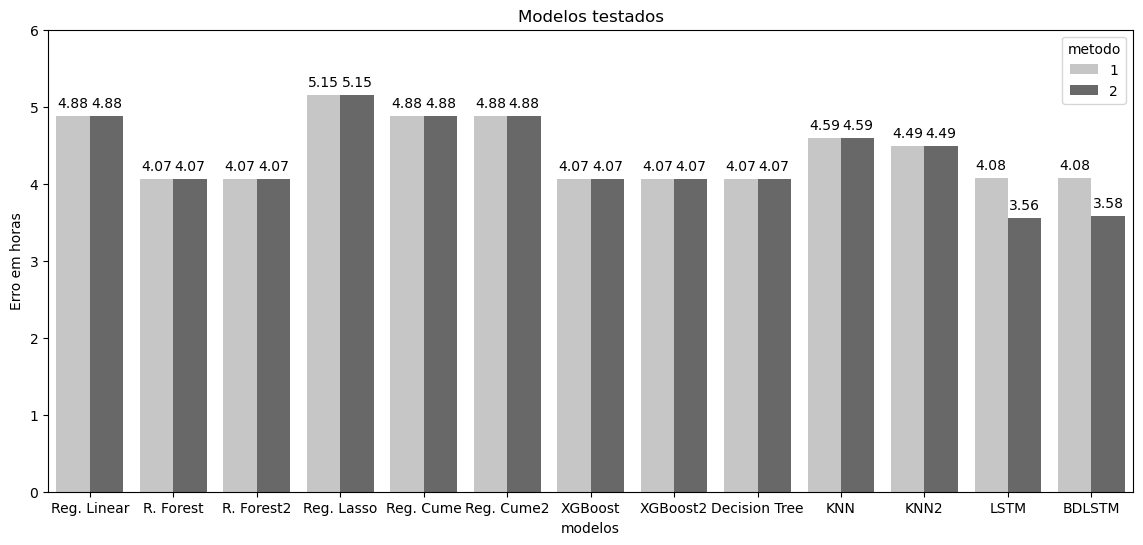

In [95]:
plt.figure(figsize = (14,6))

splot = sns.barplot(data= metricas,
            x = "modelos",
            y = "erro_medio",
            hue = "metodo",
            palette = "Greys");
splot.set_ylim(0,6)
splot.set_ylabel("Erro em horas")

plt.title("Modelos testados")


for g in splot.patches:
    splot.annotate(format(g.get_height(), '.2f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

#**11 - Conclusão**


O melhor modelo para a previsão é a Regressão Linear.